In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from cv_image_matching.feature_extraction.sift import SIFT

In [2]:
img1_path = '../../data/index.png'
img1 = cv.imread(img1_path, cv.IMREAD_COLOR)
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

Text(0.5, 1.0, 'Base image')

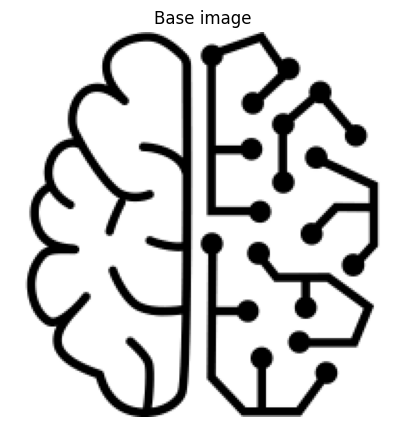

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img1)
ax.axis("off")
ax.set_title("Base image")

In [20]:
params_sift = {
    "kp_find_threshold": 1,
    "kp_max_tolerance": 2,
    "local_max_threshold": 3,
    "initial_sigma": 1.6,
    "n_scales_per_octave": 3,
    "n_octaves": 7,
    "assumed_blur": 0.5,
    "gaussian_window_histogram": 1.5,
    "num_bins_histogram": 180,
    "ksize_smooth_histogram": 5,
    "std_smooth_histogram": 1,
    "size_factor": 5,
    "n_spacial_bins": 4,
    "n_orientation_bins": 8,
    "f_max": 0.2,
    "f_scale": 512,
    "descriptor_filter_scale_factor": 0.25,
    "descriptor_cutoff_factor": 2.5,
}

sift = SIFT(**params_sift)
kp1, des1 = sift.detect_and_compute(gray1.astype(np.float32))

sift_opencv = cv.SIFT_create()
kp1_opencv, des1_opencv = sift_opencv.detectAndCompute(img1, None)

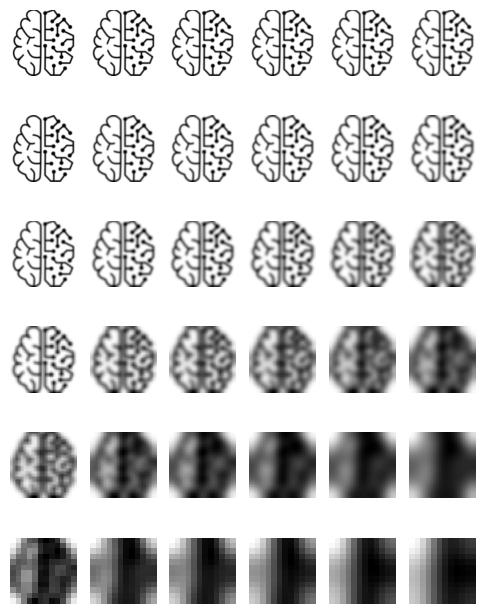

In [21]:
fig, ax = plt.subplots(sift.n_octaves-1, sift.n_intervals, figsize=(6, 8))
for octave in range(sift.n_octaves-1):
    for scale in range(sift.n_intervals):
        ax[octave][scale].imshow(sift.gaussianed_images[octave][scale], cmap='gray')
        ax[octave][scale].axis('off')

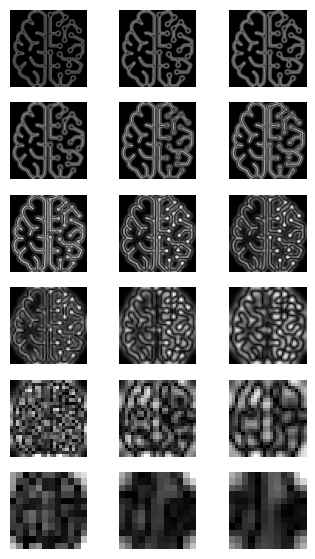

In [22]:
fig, ax = plt.subplots(sift.n_octaves-1, sift.n_scales_per_octave, figsize=(4, 7))
for octave in range(sift.n_octaves-1):
    for scale in range(sift.n_scales_per_octave):
        ax[octave][scale].imshow(abs(sift.dog_images[octave][scale]), cmap='gray')
        ax[octave][scale].axis('off')

(-0.5, 199.5, 199.5, -0.5)

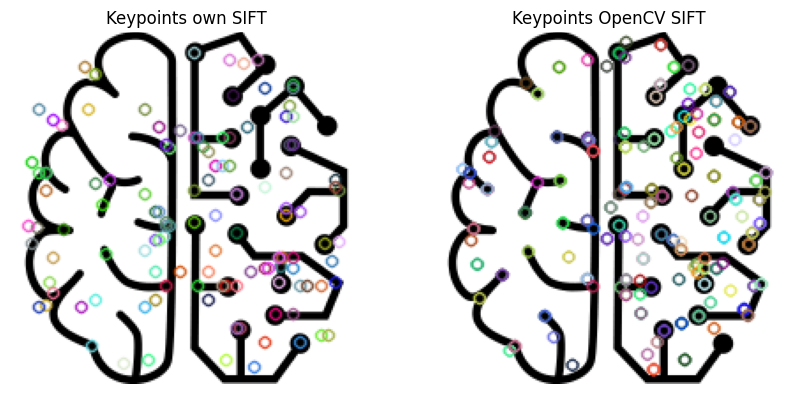

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sift_img1 = img1.copy()
sift_img2 = img1.copy()
cv.drawKeypoints(gray1, kp1, sift_img1)
cv.drawKeypoints(gray1, kp1_opencv, sift_img2)
ax[0].imshow(sift_img1)
ax[0].set_title(f"Keypoints own SIFT")
ax[0].axis("off")
ax[1].imshow(sift_img2)
ax[1].set_title(f"Keypoints OpenCV SIFT")
ax[1].axis("off")
